A first attempt at the kaggle dstl satellite competition, getting familiar witn satellite image procesing etc. The aim of the competition is to classify different objects on the ground from satellite images.

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [218]:
import pandas as pd
import numpy as np
import cv2
import time
from datetime import datetime
from joblib import Parallel, delayed
from tqdm import tqdm_notebook, tqdm

In [3]:
import tifffile as tiff
import shapely.wkt

In [4]:
from pathlib import Path
from fastai.vision import *

#### The data
Two sets of image data are provided: 3 band (rgb) and the full 16 band data. Since both are quite big,  I'll just work with the 3band (rgb) data to start with as that is more intutive. Also, the object masks are scaled to 0-1 by the competiton so we have to transform the polygons back into the right shape to match with the images

The 10 classes are:

1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
2. Misc. Manmade structures 
3. Road 
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway 
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike

In [6]:
data_dir = Path("/media/wwymak/Storage/kaggle-dstl")
data_dir.ls()

[PosixPath('/media/wwymak/Storage/kaggle-dstl/train_wkt_v4.csv'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/train_geojson_v3'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/grid_sizes.csv.zip')]

In [36]:
IMG_HEIGHT = 3349
IMG_WIDTH = 3391

The grid sizes are used to map the polygons back into the correct pixels for the image masks.

In [8]:
grid_sizes = pd.read_csv(data_dir / "grid_sizes.csv.zip", 
                         header=None,
                         skiprows=1,
                         names = ["img_id", "xmax", "ymin"], )
grid_sizes.set_index("img_id", inplace=True)
grid_sizes.head()

,xmax,ymin
img_id,,
6120_2_4,0.009180,-0.00904
6120_2_3,0.009169,-0.00904
6120_2_2,0.009188,-0.00904
6120_2_1,0.009188,-0.00904
6120_2_0,0.009188,-0.00904


These are the filepaths for a few of the images-- we can see that the x.tif matches with the ids in the label/grid_sizes keys. According to the organisers, the 3band images are all 3349 (height), 3391 (Width)

In [14]:
(data_dir /"three_band").ls()[:5]

[PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6030_1_3.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6030_3_3.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6040_2_1.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6090_1_3.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6090_4_1.tif')]

We can see that there aren't actually that many images. However, each image is huge and contains multiple classes of things. It might make life a lot easier if we chop up each image into smaller pieces, do a separate classification/segmentation on them and combine the final result... But let's process the labels/transofrmas and look at the data first

In [17]:
labels = pd.read_csv(data_dir / "train_wkt_v4.csv")
print(labels.ImageId.nunique())
labels.set_index("ImageId", inplace=True)
labels.shape

25


(250, 2)

In [20]:
test = pd.read_csv(data_dir / "sample_submission.csv")
test.ImageId.nunique()

429

In [29]:
labels.MultipolygonWKT= labels.MultipolygonWKT.apply(lambda x: shapely.wkt.loads(x))

In [27]:
labels = labels.merge(grid_sizes, left_index=True, right_index=True, how="left")
labels.head()

,ClassType,MultipolygonWKT,xmax,ymin
6010_1_2,1,MULTIPOLYGON EMPTY,0.009169,-0.009042
6010_1_2,2,MULTIPOLYGON (((0.008926999999999999 -0.008574...,0.009169,-0.009042
6010_1_2,3,MULTIPOLYGON EMPTY,0.009169,-0.009042
6010_1_2,4,"MULTIPOLYGON (((0.008765 -0.007289, 0.00885 -0...",0.009169,-0.009042
6010_1_2,5,MULTIPOLYGON (((0.007405 -0.009022000000000001...,0.009169,-0.009042


In [30]:
labels.dtypes

ClassType            int64
MultipolygonWKT     object
xmax               float64
ymin               float64
dtype: object

In [21]:
def scaler(h, w, xmax, ymin):
    w_ = w * w /( w+1)
    h_ = h * h/(h+1)
    x_scale = w_ / xmax
    y_scale = h_ / ymin
    return x_scale, y_scale

In [31]:

def scale_polygon(row):
#     print(row)
    polygon = row.MultipolygonWKT
    if not polygon:
        return
    xscale, yscale = scaler(IMG_HEIGHT, IMG_WIDTH, row["xmax"], row["ymin"])
    return shapely.affinity.scale(polygon, xfact=xscale, yfact=yscale, origin=(0,0,0))
labels["scale_poly"] = labels.apply(lambda row: scale_polygon(row), axis=1)

### Data Inspection

In [71]:
imgid = "6120_2_2"
class_type = 1
img_rgb = tiff.imread(str(data_dir / "three_band"/ f"{imgid}.tif")).transpose([1, 2, 0])
mask_polygons = labels.loc[(labels.index == imgid) & \
                           (labels.ClassType == 1) ]["scale_poly"][0]

In [158]:
def create_mask(polygons, h,w):
    img_mask = np.zeros((h,w), dtype=np.uint8)
    if polygons:
        exterior = [np.array(poly.exterior.coords).round().astype(np.int32) for poly in polygons] # the boundary of polygon
        interior = [np.array(pi.coords).round().astype(np.int32) for poly in polygons for pi in poly.interiors]#fill in internal holes
        
        cv2.fillPoly(img_mask, exterior,1)
        cv2.fillPoly(img_mask, interior,0)
    return img_mask

In [159]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

In [160]:
img_mask = create_mask(mask_polygons, IMG_HEIGHT, IMG_WIDTH)

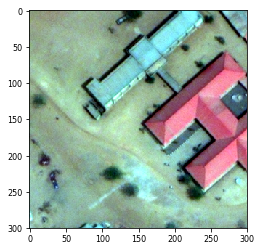

In [161]:
fig = plt.figure(figsize=(4,4))
tiff.imshow(255 * scale_percentile(img_rgb[2900:3200,2000:2300]),figure=fig);

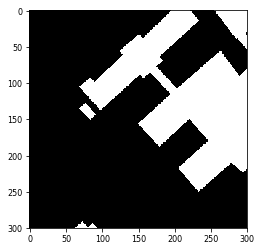

In [162]:
def show_mask(m, **kwargs):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]),  **kwargs);
fig = plt.figure(figsize=(4,4))
show_mask(img_mask[2900:3200,2000:2300],figure=fig)

#### Simple step 1:
- Unet segmentation of patches of size 150 by 150

First, create all the masks for buildings in the training set:

In [205]:
(data_dir / "building_masks_train").mkdir(exist_ok=True)
(data_dir /"building_imgs_train").mkdir(exist_ok=True)
building_masks_train_dir = data_dir / "building_masks_train"
building_imgs_train_dir = data_dir /"building_imgs_train"

In [145]:
building_labels = labels.loc[(labels.ClassType == 1) & (labels.scale_poly.notnull())]
train_imgs = [data_dir / "three_band"/ f"{imgid}.tif" for imgid in building_labels.index.unique()]

In [169]:
building_masks = [create_mask(mask_polygons, IMG_HEIGHT, IMG_WIDTH) for mask_polygons in building_labels.scale_poly]

In [170]:
building_labels["masks"] = building_masks

/home/wwymak/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [171]:
building_labels["masks"][0].shapea

(3349, 3391)

In [172]:
vertical =[np.array(np.vsplit(x[:(IMG_HEIGHT - IMG_HEIGHT%150), :], y)) for x in horizontal]

In [240]:
def create_img_mask_pairs(base_img, base_mask):
    x = np.arange(150, IMG_WIDTH-150, 150)
    y = np.arange(150, IMG_HEIGHT-150, 150)
    horizontal_masks =np.array(np.hsplit(base_mask[:, :(IMG_WIDTH - IMG_WIDTH%150)], x))
    horizontal_imgs =np.array(np.hsplit(base_img[:, :(IMG_WIDTH - IMG_WIDTH%150)], x))
    
    mask_patchs = [np.array(np.vsplit(horizontal[:(IMG_HEIGHT - IMG_HEIGHT%150), :], y)) for horizontal in horizontal_masks]
    img_patchs = [np.array(np.vsplit(horizontal[:(IMG_HEIGHT - IMG_HEIGHT%150), :], y)) for horizontal in horizontal_imgs]
    
    return mask_patchs, img_patchs

def save_mask_imgs_patches(img_fname, base_mask):

    img_rgb = tiff.imread(str(data_dir / "three_band"/ f"{img_fname}.tif")).transpose([1, 2, 0])
    mask_patchs, img_patchs = create_img_mask_pairs(img_rgb,base_mask)
    
    for i in range(len(mask_patchs)):
        for j in range(mask_patchs[i].shape[0]):
            mask = PIL.Image.fromarray(mask_patchs[i][j])
            img = PIL.Image.fromarray((255* scale_percentile(img_patchs[i][j])).astype(np.uint8))
            mask.save(building_masks_train_dir/ f"{img_fname}_{i}_{j}.png" )
            img.save(building_imgs_train_dir/ f"{img_fname}_{i}_{j}.png" )

    
def save_mask_imgs_patches_row(row):
    img_fname = row["index"]
    base_mask = row["masks"]
    img_rgb = tiff.imread(str(data_dir / "three_band"/ f"{img_fname}.tif")).transpose([1, 2, 0])
    mask_patchs, img_patchs = create_img_mask_pairs(img_rgb,base_mask)
    
    for i in range(len(mask_patchs)):
        for j in range(mask_patchs[i].shape[0]):
            mask = PIL.Image.fromarray(mask_patchs[i][j])
            img = PIL.Image.fromarray((255* scale_percentile(img_patchs[i][j])).astype(np.uint8))
            mask.save(building_masks_train_dir/ f"{img_fname}_{i}_{j}.png" )
            img.save(building_imgs_train_dir/ f"{img_fname}_{i}_{j}.png" )
    end = datetime.now()
    print(end - start)

In [241]:
start = datetime.now()
building_labels.reset_index().apply(lambda row: save_mask_imgs_patches(row["index"], row["masks"]), axis=1)
end = datetime.now()
print(end-start)

0:00:29.277487


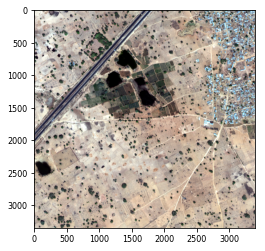

In [226]:
img_rgb = tiff.imread(str(data_dir / "three_band"/ f"{building_labels.index[7]}.tif")).transpose([1, 2, 0])
fig = plt.figure(figsize=(4,4))
tiff.imshow(255 * scale_percentile(img_rgb),figure=fig);

In [242]:
a = building_masks_train_dir.ls()
idx = np.random.choice(np.arange(len(a)), 9)

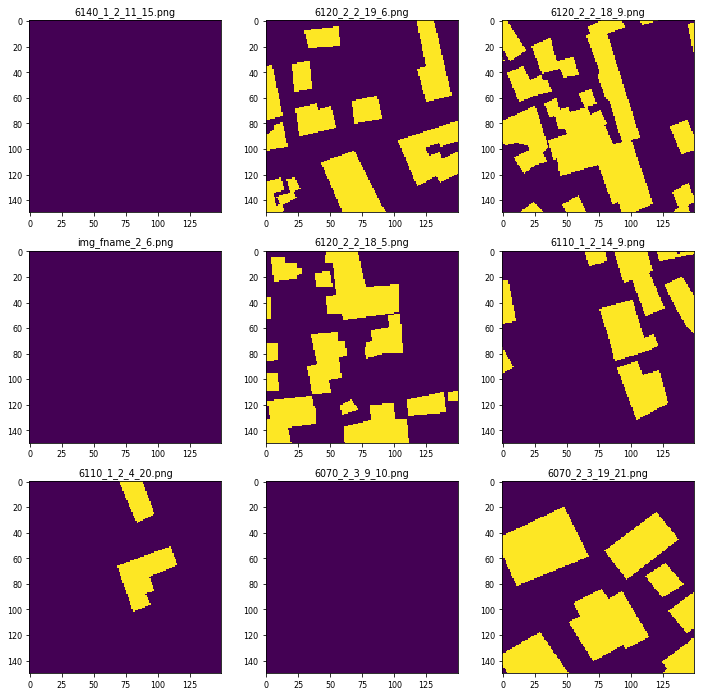

In [243]:
fig, axs = plt.subplots(3,3, figsize=(12,12))
nrows = 3
i = 0
for ax in axs.flat:
    ax.imshow(PIL.Image.open(a[i]))
    ax.set_title(a[i].name)
    i +=1

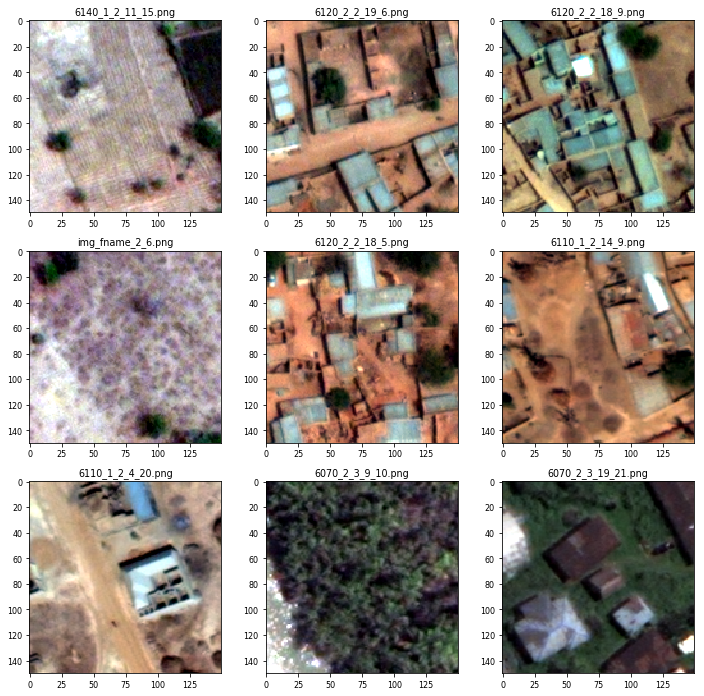

In [244]:
b = building_imgs_train_dir.ls()
fig, axs = plt.subplots(3,3, figsize=(12,12))
nrows = 3
i = 0
for ax in axs.flat:
    ax.imshow(PIL.Image.open(b[i]))
    ax.set_title(b[i].name)
    i +=1